<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [158]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input
import pandas as pd
import numpy as np
from librosa.core import resample, load
from librosa.util import fix_length
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay,
    roc_auc_score, roc_curve, auc
)
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

In [14]:
data = pd.read_csv('clean.csv')

In [21]:
all_classes = [c for c in data.columns if c.startswith('class')]
class_count = data[all_classes].idxmax(axis=1).value_counts()
class_count

class_Snare        2166
class_Kick         1556
class_Hat          1289
class_Tom          1268
class_Cymbal        722
class_Clap          307
class_Cowbell       152
class_Conga         120
class_Shaken        104
class_Tambourin      75
class_Bongo          60
class_Agogo          56
class_Clave          54
class_Timbales       49
class_Djembe         20
class_Guiro          19
class_Cajon          12
class_Cuica          10
class_Timpani        10
class_Tabla           9
class_Triangle        8
class_Gong            4
class_Darbuka         4
class_clave           2
dtype: int64

In [22]:
classes_cols = class_count[class_count > 100].index

In [23]:
nb_classes = len(classes_cols)
data = data[data[classes_cols].sum(axis=1) == 1]

In [24]:
data.shape

(7684, 45)

In [25]:
data.head()

,path,filename,dir_1,class_Hat,subclass_Hat_Open,subclass_Hat_Close,class_Bongo,class_Cymbal,subclass_Cymbal_Crash,subclass_Cymbal_Ride,...,subclass_Shaken_Maracas,class_Cajon,class_clave,dir_2,subclass_Snare_Off,subclass_Snare_On,subclass_Snare_Side,subclass_Snare_Flam,subclass_Snare_Brush,subclass_Cymbal_Trash
0,./Samples/200-drum-machines/Yamaha RX-11/MaxV ...,MaxV - RX11 OPHAT2.wav,Yamaha RX-11,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0
1,./Samples/200-drum-machines/Yamaha RX-11/MaxV ...,MaxV - RX11 BD3.wav,Yamaha RX-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0
2,./Samples/200-drum-machines/Yamaha RX-11/MaxV ...,MaxV - RX11 BD2.wav,Yamaha RX-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0
3,./Samples/200-drum-machines/Yamaha RX-11/MaxV ...,MaxV - RX11 CLHAT2.wav,Yamaha RX-11,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0
4,./Samples/200-drum-machines/Yamaha RX-11/MaxV ...,MaxV - RX11 RIDE.wav,Yamaha RX-11,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
data = data.loc[data['path'] != './Samples/200-drum-machines/Roland JV 1080/MaxV - Guiro.wav']

In [27]:
vggish = hub.load('https://tfhub.dev/google/vggish/1')
yamnet = hub.load('https://tfhub.dev/google/yamnet/1')

In [31]:
SR=16000
classes = data[classes_cols]
files = data['path']
vgg_embeddings = []
yam_embeddings = []
for path in tqdm(files):
    sound, _ = load(path, sr=SR)
    sound = fix_length(sound, 1*SR)
    vgg_embeddings.append(vggish(sound))
    _, yam_emb, _ = yamnet(sound)
    yam_embeddings.append(yam_emb[0])

vgg_embeddings = np.stack(vgg_embeddings)
yam_embeddings = np.stack(yam_embeddings)

<ipython-input-31-131a48f41366>:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for path in tqdm_notebook(files):


In [32]:
vgg_embeddings.shape, yam_embeddings.shape

((7684, 1, 128), (7684, 1024))

In [33]:
vgg_embeddings = vgg_embeddings.reshape(-1, 128)
yam_embeddings = yam_embeddings.reshape(-1, 1024)

In [34]:
# x_train, x_valid, y_train, y_valid = train_test_split(sounds, classes, test_size=0.3, stratify=classes)
x_vgg_train, x_vgg_valid, x_yam_train, x_yam_valid, y_train, y_valid = train_test_split(vgg_embeddings, yam_embeddings, classes, test_size=0.3, stratify=classes)

In [35]:
x_vgg_train.shape

(5378, 128)

In [140]:
inputs = Input(shape=(128))
x = Dense(100, activation='relu')(inputs)
x = Dropout(0.3)(x)
x = Dense(50, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(nb_classes, activation='softmax')(x)

model = Model(inputs, outputs)
model.summary()

Model: "functional_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 128)]             0         
_________________________________________________________________
dense_46 (Dense)             (None, 100)               12900     
_________________________________________________________________
dropout_23 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_47 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_24 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_48 (Dense)             (None, 9)                 459       
Total params: 18,409
Trainable params: 18,409
Non-trainable params: 0
_________________________________________________

In [141]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [142]:
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=classes_cols,
    y=y_train.idxmax(axis=1))

class_weights = dict(zip(range(nb_classes), class_weights))
class_weights

{0: 0.3941659337437702,
 1: 0.5487195184164881,
 2: 0.6624784429662478,
 3: 0.6729229229229229,
 4: 1.1832783278327832,
 5: 2.779328165374677,
 6: 5.637316561844863,
 7: 7.113756613756614,
 8: 8.185692541856925}

In [143]:
history = model.fit(x_vgg_train, y_train, epochs=100, class_weight=class_weights, validation_data=(x_vgg_valid, y_valid))

Epoch 1/100
169/169 [==============================] - 0s 2ms/step - loss: 1.7506 - accuracy: 0.3611 - val_loss: 1.2969 - val_accuracy: 0.5299
Epoch 2/100
169/169 [==============================] - 0s 1ms/step - loss: 1.1010 - accuracy: 0.5009 - val_loss: 0.9574 - val_accuracy: 0.6422
Epoch 3/100
169/169 [==============================] - 0s 1ms/step - loss: 0.9027 - accuracy: 0.5762 - val_loss: 0.9372 - val_accuracy: 0.6401
Epoch 4/100
169/169 [==============================] - 0s 1ms/step - loss: 0.8386 - accuracy: 0.5976 - val_loss: 0.8452 - val_accuracy: 0.6791
Epoch 5/100
169/169 [==============================] - 0s 1ms/step - loss: 0.7826 - accuracy: 0.6277 - val_loss: 0.8001 - val_accuracy: 0.7029
Epoch 6/100
169/169 [==============================] - 0s 1ms/step - loss: 0.7406 - accuracy: 0.6512 - val_loss: 0.7661 - val_accuracy: 0.7138
Epoch 7/100
169/169 [==============================] - 0s 1ms/step - loss: 0.7091 - accuracy: 0.6657 - val_loss: 0.7511 - val_accuracy: 0.7160

Epoch 58/100
169/169 [==============================] - 0s 1ms/step - loss: 0.3418 - accuracy: 0.8141 - val_loss: 0.5469 - val_accuracy: 0.8044
Epoch 59/100
169/169 [==============================] - 0s 1ms/step - loss: 0.3471 - accuracy: 0.8152 - val_loss: 0.5353 - val_accuracy: 0.8096
Epoch 60/100
169/169 [==============================] - 0s 1ms/step - loss: 0.3374 - accuracy: 0.8135 - val_loss: 0.5282 - val_accuracy: 0.8092
Epoch 61/100
169/169 [==============================] - 0s 2ms/step - loss: 0.3450 - accuracy: 0.8148 - val_loss: 0.5586 - val_accuracy: 0.8010
Epoch 62/100
169/169 [==============================] - 0s 1ms/step - loss: 0.3481 - accuracy: 0.8144 - val_loss: 0.5555 - val_accuracy: 0.7984
Epoch 63/100
169/169 [==============================] - 0s 1ms/step - loss: 0.3382 - accuracy: 0.8174 - val_loss: 0.5526 - val_accuracy: 0.8096
Epoch 64/100
169/169 [==============================] - 0s 1ms/step - loss: 0.3219 - accuracy: 0.8243 - val_loss: 0.5277 - val_accuracy:

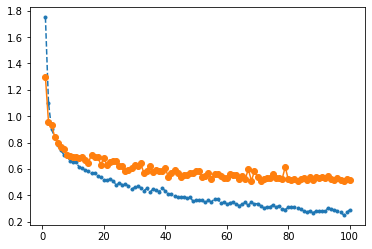

In [144]:
loss = history.history['loss']
epochs = range(1, len(loss) + 1)
val_loss = history.history['val_loss']
plt.plot(epochs, loss, '.--', label='Training loss')
plt.plot(epochs, val_loss, 'o-', label='Validation loss')
plt.show()

In [145]:
y_pred = model.predict(x_vgg_valid)
y_pred = np.argmax(y_pred,axis=1).astype(int)
y_valid_index = np.argmax(y_valid.values,axis=1).astype(int)

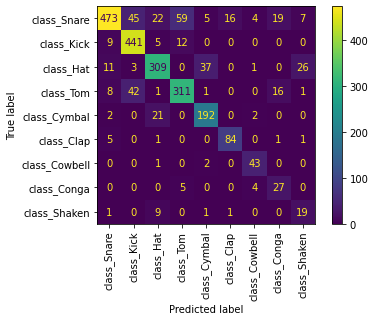

In [146]:
conf_matrix = ConfusionMatrixDisplay(
    confusion_matrix(y_valid_index, y_pred),
    display_labels=classes_cols,
)
conf_matrix.plot(xticks_rotation=90);

In [147]:
print(classification_report(y_valid_index, y_pred, target_names=classes_cols))

               precision    recall  f1-score   support

  class_Snare       0.93      0.73      0.82       650
   class_Kick       0.83      0.94      0.88       467
    class_Hat       0.84      0.80      0.82       387
    class_Tom       0.80      0.82      0.81       380
 class_Cymbal       0.81      0.88      0.84       217
   class_Clap       0.83      0.91      0.87        92
class_Cowbell       0.80      0.93      0.86        46
  class_Conga       0.43      0.75      0.55        36
 class_Shaken       0.35      0.61      0.45        31

     accuracy                           0.82      2306
    macro avg       0.74      0.82      0.77      2306
 weighted avg       0.84      0.82      0.83      2306



In [176]:
roc_auc_score(y_valid_index, model.predict(x_vgg_valid), average='weighted', multi_class='ovr')

0.9804428135728175

In [181]:
y_pred = model.predict(x_vgg_valid)
(y_pred-y_valid).idxmax(axis=1)

3473       class_Tom
3803    class_Cymbal
6181       class_Hat
1976     class_Snare
3952       class_Hat
            ...     
1112     class_Conga
5789      class_Kick
3736       class_Hat
100      class_Snare
1441     class_Snare
Length: 2306, dtype: object

In [148]:
inputs = Input(shape=(1024))
x = Dropout(0.3)(inputs)
x = Dense(100, activation='relu')(x)
x = Dropout(0.3)(inputs)
x = Dense(50, activation='relu')(x)
x = Dropout(0.3)(inputs)
outputs = Dense(nb_classes, activation='softmax')(x)

model2 = Model(inputs, outputs)
model2.summary()

Model: "functional_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 1024)]            0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_51 (Dense)             (None, 9)                 9225      
Total params: 9,225
Trainable params: 9,225
Non-trainable params: 0
_________________________________________________________________


In [149]:
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [150]:
history = model2.fit(x_yam_train, y_train, epochs=100, validation_data=(x_yam_valid, y_valid))

Epoch 1/100
169/169 [==============================] - 0s 2ms/step - loss: 1.4630 - accuracy: 0.4769 - val_loss: 1.1567 - val_accuracy: 0.5794
Epoch 2/100
169/169 [==============================] - 0s 2ms/step - loss: 1.0745 - accuracy: 0.6162 - val_loss: 0.9779 - val_accuracy: 0.6479
Epoch 3/100
169/169 [==============================] - 0s 2ms/step - loss: 0.9505 - accuracy: 0.6616 - val_loss: 0.8887 - val_accuracy: 0.6899
Epoch 4/100
169/169 [==============================] - 0s 1ms/step - loss: 0.8922 - accuracy: 0.6761 - val_loss: 0.8388 - val_accuracy: 0.7056
Epoch 5/100
169/169 [==============================] - 0s 1ms/step - loss: 0.8482 - accuracy: 0.6997 - val_loss: 0.8021 - val_accuracy: 0.7164
Epoch 6/100
169/169 [==============================] - 0s 1ms/step - loss: 0.8130 - accuracy: 0.7122 - val_loss: 0.7766 - val_accuracy: 0.7277
Epoch 7/100
169/169 [==============================] - 0s 1ms/step - loss: 0.7918 - accuracy: 0.7148 - val_loss: 0.7556 - val_accuracy: 0.7333

Epoch 58/100
169/169 [==============================] - 0s 1ms/step - loss: 0.5863 - accuracy: 0.7960 - val_loss: 0.6057 - val_accuracy: 0.7975
Epoch 59/100
169/169 [==============================] - 0s 2ms/step - loss: 0.5806 - accuracy: 0.7841 - val_loss: 0.6021 - val_accuracy: 0.7910
Epoch 60/100
169/169 [==============================] - 0s 2ms/step - loss: 0.5853 - accuracy: 0.7858 - val_loss: 0.6024 - val_accuracy: 0.7845
Epoch 61/100
169/169 [==============================] - 0s 2ms/step - loss: 0.5880 - accuracy: 0.7854 - val_loss: 0.6033 - val_accuracy: 0.7879
Epoch 62/100
169/169 [==============================] - 0s 2ms/step - loss: 0.5821 - accuracy: 0.7906 - val_loss: 0.6009 - val_accuracy: 0.7931
Epoch 63/100
169/169 [==============================] - 0s 2ms/step - loss: 0.5887 - accuracy: 0.7877 - val_loss: 0.5969 - val_accuracy: 0.7979
Epoch 64/100
169/169 [==============================] - 0s 2ms/step - loss: 0.5728 - accuracy: 0.7945 - val_loss: 0.5986 - val_accuracy:

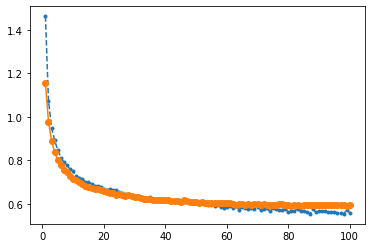

In [151]:
loss = history.history['loss']
epochs = range(1, len(loss) + 1)
val_loss = history.history['val_loss']
plt.plot(epochs, loss, '.--', label='Training loss')
plt.plot(epochs, val_loss, 'o-', label='Validation loss')
plt.show()

In [152]:
y_pred = model2.predict(x_yam_valid)
y_pred = np.argmax(y_pred,axis=1).astype(int)

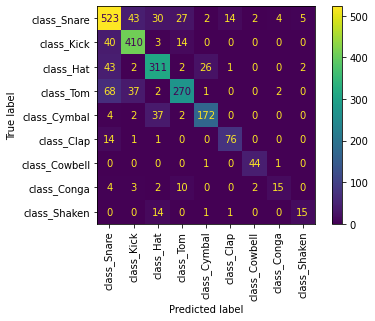

In [153]:
conf_matrix = ConfusionMatrixDisplay(
    confusion_matrix(y_valid_index, y_pred),
    display_labels=classes_cols,
)
conf_matrix.plot(xticks_rotation=90);

In [154]:
print(classification_report(y_valid_index, y_pred, target_names=classes_cols))

               precision    recall  f1-score   support

  class_Snare       0.75      0.80      0.78       650
   class_Kick       0.82      0.88      0.85       467
    class_Hat       0.78      0.80      0.79       387
    class_Tom       0.83      0.71      0.77       380
 class_Cymbal       0.85      0.79      0.82       217
   class_Clap       0.83      0.83      0.83        92
class_Cowbell       0.92      0.96      0.94        46
  class_Conga       0.68      0.42      0.52        36
 class_Shaken       0.68      0.48      0.57        31

     accuracy                           0.80      2306
    macro avg       0.79      0.74      0.76      2306
 weighted avg       0.80      0.80      0.79      2306



In [177]:
roc_auc_score(y_valid_index, model2.predict(x_yam_valid), average='weighted', multi_class='ovr')

0.9603069132403973

In [155]:
model.trainable = False
inputs = model.inputs
x = model.get_layer(index=-3).output
outputs = Dense(1, activation='sigmoid')(x)
model3 = Model(inputs, outputs)
model3.summary()
model3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
total = len(y_train['class_Shaken'])
positive = (y_train['class_Shaken'] == 1).sum()
negative = (y_train['class_Shaken'] == 0).sum()
weights = {0:(1 / negative)*(total)/2.0 ,1:(1 / positive)*(total)/2.0}
history = model3.fit(x_vgg_train, y_train['class_Shaken'], epochs=100, class_weight=weights, validation_data=(x_vgg_valid, y_valid['class_Shaken']))

Model: "functional_39"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 128)]             0         
_________________________________________________________________
dense_46 (Dense)             (None, 100)               12900     
_________________________________________________________________
dropout_23 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_47 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_52 (Dense)             (None, 1)                 51        
Total params: 18,001
Trainable params: 51
Non-trainable params: 17,950
_________________________________________________________________
Epoch 1/100
169/169 [==============================] - 0s 2ms/step - loss: 0.3592 - accuracy: 0.7793 - val_loss: 0

Epoch 51/100
169/169 [==============================] - 0s 1ms/step - loss: 0.0380 - accuracy: 0.9797 - val_loss: 0.0766 - val_accuracy: 0.9766
Epoch 52/100
169/169 [==============================] - 0s 1ms/step - loss: 0.0405 - accuracy: 0.9801 - val_loss: 0.0811 - val_accuracy: 0.9753
Epoch 53/100
169/169 [==============================] - 0s 1ms/step - loss: 0.0378 - accuracy: 0.9814 - val_loss: 0.0814 - val_accuracy: 0.9748
Epoch 54/100
169/169 [==============================] - 0s 1ms/step - loss: 0.0302 - accuracy: 0.9814 - val_loss: 0.0754 - val_accuracy: 0.9775
Epoch 55/100
169/169 [==============================] - 0s 1ms/step - loss: 0.0471 - accuracy: 0.9807 - val_loss: 0.0808 - val_accuracy: 0.9757
Epoch 56/100
169/169 [==============================] - 0s 1ms/step - loss: 0.0463 - accuracy: 0.9801 - val_loss: 0.0823 - val_accuracy: 0.9748
Epoch 57/100
169/169 [==============================] - 0s 1ms/step - loss: 0.0426 - accuracy: 0.9807 - val_loss: 0.0833 - val_accuracy:

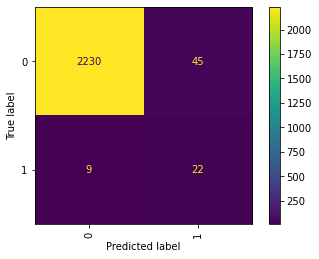

In [156]:
y_pred = model3.predict(x_vgg_valid)
y_pred = (y_pred > 0.5).astype(int)
conf_matrix = ConfusionMatrixDisplay(
    confusion_matrix(y_valid['class_Shaken'], y_pred),
)
conf_matrix.plot(xticks_rotation=90);

In [157]:
print(classification_report(y_valid['class_Shaken'], y_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99      2275
         1.0       0.33      0.71      0.45        31

    accuracy                           0.98      2306
   macro avg       0.66      0.84      0.72      2306
weighted avg       0.99      0.98      0.98      2306



0.977298830202056


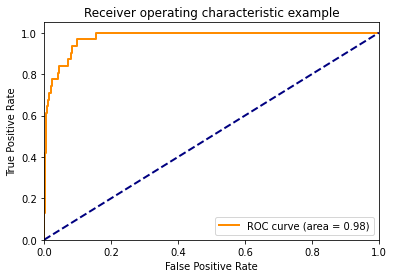

In [161]:
fpr, tpr, _ = roc_curve(y_valid['class_Shaken'], model3.predict(x_vgg_valid))
roc_auc = auc(fpr, tpr)
print(roc_auc)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()